In [1]:
#importando bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from prince import FAMD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# setting up plot style 
style.use('seaborn-poster')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)


In [2]:
#import dataset

df = pd.read_csv('../datasets/data_to_clustering.csv')
#df.drop(columns = 'not_defined', inplace = True)
df.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,review_score,price,freight_value,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,seller_state
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,1.0,credit_card,1.0,18.12,SP
1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,3.0,voucher,1.0,2.00,SP
2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,2.0,voucher,1.0,18.59,SP
3,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,barreiras,BA,4,118.70,22.76,perfumaria,1.0,boleto,1.0,141.46,SP
4,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,vianopolis,GO,5,159.90,19.22,automotivo,1.0,credit_card,3.0,179.12,SP


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105291 entries, 0 to 105290
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_purchase_timestamp       105291 non-null  object 
 1   order_approved_at              105291 non-null  object 
 2   order_delivered_carrier_date   105291 non-null  object 
 3   order_delivered_customer_date  105291 non-null  object 
 4   order_estimated_delivery_date  105291 non-null  object 
 5   customer_city                  105291 non-null  object 
 6   customer_state                 105291 non-null  object 
 7   review_score                   105291 non-null  int64  
 8   price                          105291 non-null  float64
 9   freight_value                  105291 non-null  float64
 10  product_category_name          105291 non-null  object 
 11  payment_sequential             105291 non-null  float64
 12  payment_type                  

# Feature Engineering

## Date Columns

Add columns that are the difference between `order purchase` and anothers date columns

In [4]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

In [5]:
df['diff_approved'] = df['order_approved_at'] - df['order_purchase_timestamp'] #diff data aprovação da compra - data da compra
df['diff_carrier'] = df['order_delivered_carrier_date'] - df['order_purchase_timestamp']
df['diff_customer'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']
df['diff_estimate'] = df['order_estimated_delivery_date'] - df['order_purchase_timestamp']
df['diff_est_del'] = df['order_estimated_delivery_date'] - df['order_delivered_customer_date']

#transforming the values in days difference
df['diff_approved']=df['diff_approved']/np.timedelta64(1,'D')
df['diff_carrier']=df['diff_carrier']/np.timedelta64(1,'D')
df['diff_customer']=df['diff_customer']/np.timedelta64(1,'D')
df['diff_estimate']=df['diff_estimate']/np.timedelta64(1,'D')
df['diff_est_del']=df['diff_est_del']/np.timedelta64(1,'D')

df.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,review_score,price,freight_value,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,seller_state,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,1.0,credit_card,1.0,18.12,SP,0.007431,2.373924,8.436574,15.544063,7.107488
1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,3.0,voucher,1.0,2.00,SP,0.007431,2.373924,8.436574,15.544063,7.107488
2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,2.0,voucher,1.0,18.59,SP,0.007431,2.373924,8.436574,15.544063,7.107488
3,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,barreiras,BA,4,118.70,22.76,perfumaria,1.0,boleto,1.0,141.46,SP,1.279745,1.742627,13.782037,19.137766,5.355729
4,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,vianopolis,GO,5,159.90,19.22,automotivo,1.0,credit_card,3.0,179.12,SP,0.011505,0.216100,9.394213,26.639711,17.245498


In [6]:
#drop date columns
cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
        'order_delivered_customer_date', 'order_estimated_delivery_date']

df.drop(columns = cols, axis= 1, inplace = True)
df.head()

,customer_city,customer_state,review_score,price,freight_value,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,seller_state,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del
0,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,1.0,credit_card,1.0,18.12,SP,0.007431,2.373924,8.436574,15.544063,7.107488
1,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,3.0,voucher,1.0,2.00,SP,0.007431,2.373924,8.436574,15.544063,7.107488
2,sao paulo,SP,4,29.99,8.72,utilidades_domesticas,2.0,voucher,1.0,18.59,SP,0.007431,2.373924,8.436574,15.544063,7.107488
3,barreiras,BA,4,118.70,22.76,perfumaria,1.0,boleto,1.0,141.46,SP,1.279745,1.742627,13.782037,19.137766,5.355729
4,vianopolis,GO,5,159.90,19.22,automotivo,1.0,credit_card,3.0,179.12,SP,0.011505,0.216100,9.394213,26.639711,17.245498


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105291 entries, 0 to 105290
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_city          105291 non-null  object 
 1   customer_state         105291 non-null  object 
 2   review_score           105291 non-null  int64  
 3   price                  105291 non-null  float64
 4   freight_value          105291 non-null  float64
 5   product_category_name  105291 non-null  object 
 6   payment_sequential     105291 non-null  float64
 7   payment_type           105291 non-null  object 
 8   payment_installments   105291 non-null  float64
 9   payment_value          105291 non-null  float64
 10  seller_state           105291 non-null  object 
 11  diff_approved          105291 non-null  float64
 12  diff_carrier           105291 non-null  float64
 13  diff_customer          105291 non-null  float64
 14  diff_estimate          105291 non-nu

## Customer and Seller state

In [8]:
#create a regions list
norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
nordeste = ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
centro_oeste = ['MT', 'MS', 'GO']
sul = ['PR', 'RS', 'SC']
sudeste = ['SP', 'RJ', 'ES', 'MG']

In [9]:
#create a new feature based in region list
def region (row):
    val = ""
    if row['customer_state'] in norte:
        val = 'norte'
    elif row['customer_state'] in nordeste:
        val = 'nordeste'
    elif row['customer_state'] in centro_oeste:
        val = 'centro_oeste'
    elif row['customer_state'] in sul:
        val = 'sul'
    elif row['customer_state'] in sudeste:
        val = 'sudeste'
    return val

In [10]:
df['customer_region'] = df.apply(region, axis = 1)

In [11]:
#drop the customer_state colum
df.drop(columns = 'customer_state', axis = 1, inplace = True)
df.head()

,customer_city,review_score,price,freight_value,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,seller_state,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,customer_region
0,sao paulo,4,29.99,8.72,utilidades_domesticas,1.0,credit_card,1.0,18.12,SP,0.007431,2.373924,8.436574,15.544063,7.107488,sudeste
1,sao paulo,4,29.99,8.72,utilidades_domesticas,3.0,voucher,1.0,2.00,SP,0.007431,2.373924,8.436574,15.544063,7.107488,sudeste
2,sao paulo,4,29.99,8.72,utilidades_domesticas,2.0,voucher,1.0,18.59,SP,0.007431,2.373924,8.436574,15.544063,7.107488,sudeste
3,barreiras,4,118.70,22.76,perfumaria,1.0,boleto,1.0,141.46,SP,1.279745,1.742627,13.782037,19.137766,5.355729,nordeste
4,vianopolis,5,159.90,19.22,automotivo,1.0,credit_card,3.0,179.12,SP,0.011505,0.216100,9.394213,26.639711,17.245498,centro_oeste


In [12]:
# repeat to sellers

def region (row):
    val = ""
    if row['seller_state'] in norte:
        val = 'norte'
    elif row['seller_state'] in nordeste:
        val = 'nordeste'
    elif row['seller_state'] in centro_oeste:
        val = 'centro_oeste'
    elif row['seller_state'] in sul:
        val = 'sul'
    elif row['seller_state'] in sudeste:
        val = 'sudeste'
    return val

df['seller_region'] = df.apply(region, axis = 1)

#drop the seller_state colum
df.drop(columns = 'seller_state', axis = 1, inplace = True)
df.head()

,customer_city,review_score,price,freight_value,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,customer_region,seller_region
0,sao paulo,4,29.99,8.72,utilidades_domesticas,1.0,credit_card,1.0,18.12,0.007431,2.373924,8.436574,15.544063,7.107488,sudeste,sudeste
1,sao paulo,4,29.99,8.72,utilidades_domesticas,3.0,voucher,1.0,2.00,0.007431,2.373924,8.436574,15.544063,7.107488,sudeste,sudeste
2,sao paulo,4,29.99,8.72,utilidades_domesticas,2.0,voucher,1.0,18.59,0.007431,2.373924,8.436574,15.544063,7.107488,sudeste,sudeste
3,barreiras,4,118.70,22.76,perfumaria,1.0,boleto,1.0,141.46,1.279745,1.742627,13.782037,19.137766,5.355729,nordeste,sudeste
4,vianopolis,5,159.90,19.22,automotivo,1.0,credit_card,3.0,179.12,0.011505,0.216100,9.394213,26.639711,17.245498,centro_oeste,sudeste


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105291 entries, 0 to 105290
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_city          105291 non-null  object 
 1   review_score           105291 non-null  int64  
 2   price                  105291 non-null  float64
 3   freight_value          105291 non-null  float64
 4   product_category_name  105291 non-null  object 
 5   payment_sequential     105291 non-null  float64
 6   payment_type           105291 non-null  object 
 7   payment_installments   105291 non-null  float64
 8   payment_value          105291 non-null  float64
 9   diff_approved          105291 non-null  float64
 10  diff_carrier           105291 non-null  float64
 11  diff_customer          105291 non-null  float64
 12  diff_estimate          105291 non-null  float64
 13  diff_est_del           105291 non-null  float64
 14  customer_region        105291 non-nu

In [14]:
df.head()

,customer_city,review_score,price,freight_value,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,customer_region,seller_region
0,sao paulo,4,29.99,8.72,utilidades_domesticas,1.0,credit_card,1.0,18.12,0.007431,2.373924,8.436574,15.544063,7.107488,sudeste,sudeste
1,sao paulo,4,29.99,8.72,utilidades_domesticas,3.0,voucher,1.0,2.00,0.007431,2.373924,8.436574,15.544063,7.107488,sudeste,sudeste
2,sao paulo,4,29.99,8.72,utilidades_domesticas,2.0,voucher,1.0,18.59,0.007431,2.373924,8.436574,15.544063,7.107488,sudeste,sudeste
3,barreiras,4,118.70,22.76,perfumaria,1.0,boleto,1.0,141.46,1.279745,1.742627,13.782037,19.137766,5.355729,nordeste,sudeste
4,vianopolis,5,159.90,19.22,automotivo,1.0,credit_card,3.0,179.12,0.011505,0.216100,9.394213,26.639711,17.245498,centro_oeste,sudeste


## Applying FAMD

In [15]:
famd = FAMD(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)

famd.fit(df)
famd_components = famd.transform(df)
famd_components.head()


,0,1
0,-1.243352,0.239451
1,-1.471762,-0.515468
2,-1.423938,-0.401088
3,0.812835,-0.979298
4,-0.204525,-0.053723


ax = famd.plot_row_coordinates(
    df,
    ax=None,
    figsize=(12, 8),
    x_component=0,
    y_component=1,
    labels = df['review_score'],
    color_labels=['Review Score {}'.format(t) for t in df['review_score']],
    ellipse_outline=False,
    ellipse_fill=True,
    show_points=True
)



Text(0, 0.5, 'Inertia')

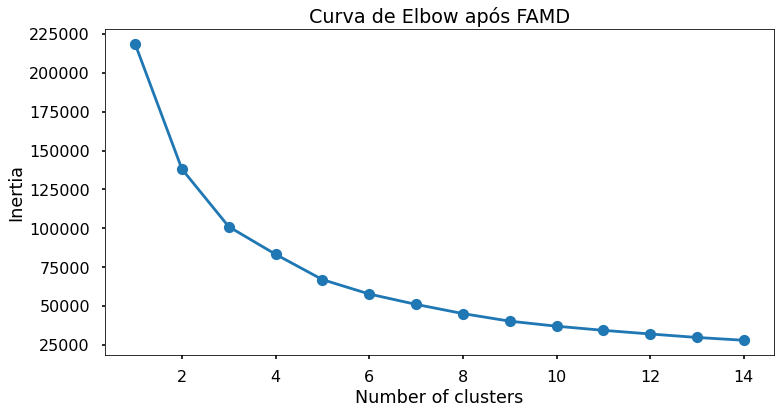

In [16]:

sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(famd_components)
    sse.append([k, km.inertia_])
    
famd_n_cluster = pd.DataFrame({'n_cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Curva de Elbow após FAMD')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# testar com k = 4!!

In [17]:
#applying kmeans in FAMD components

kmeans_famd = KMeans(n_clusters=4, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(famd_components)

print('KMeans - FAMD Silhouette Score: {}'.format(silhouette_score(famd_components, kmeans_famd.labels_, metric='euclidean')))
labels_famd = kmeans_famd.labels_
clusters_famd = pd.concat([famd_components, pd.DataFrame({'famd_clusters':labels_famd})], axis=1)

KMeans - FAMD Silhouette Score: 0.3626523536437568


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


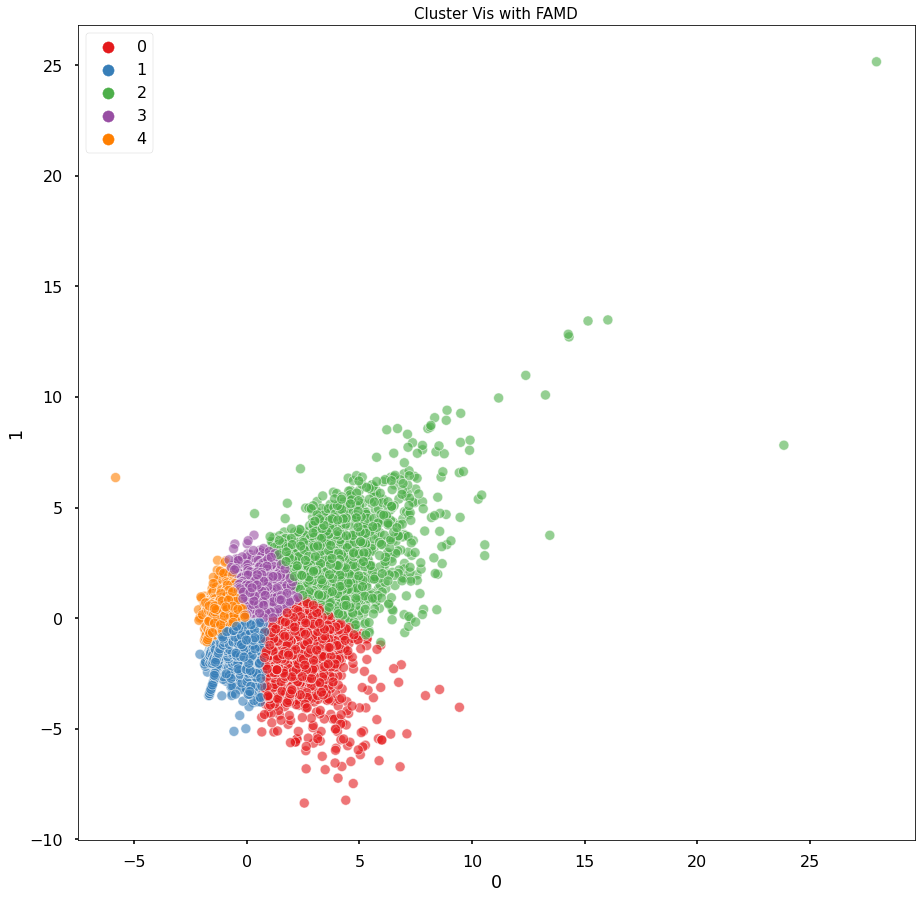

In [18]:
plt.figure(figsize = (15,15))
sns.scatterplot(clusters_famd.iloc[:,0],clusters_famd.iloc[:,1],hue=clusters_famd['famd_clusters'], 
                palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis with FAMD', fontsize=15)
plt.legend()
plt.show()

In [26]:
clusters_famd['famd_clusters'].value_counts()

4    43725
1    25633
3    20829
0    13068
2     2036
Name: famd_clusters, dtype: int64

In [19]:
cluster_famd_profile = pd.merge(df, clusters_famd['famd_clusters'], left_index=True, right_index=True )
cluster_famd_profile.head()

,customer_city,review_score,price,freight_value,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,customer_region,seller_region,famd_clusters
0,sao paulo,4,29.99,8.72,utilidades_domesticas,1.0,credit_card,1.0,18.12,0.007431,2.373924,8.436574,15.544063,7.107488,sudeste,sudeste,4
1,sao paulo,4,29.99,8.72,utilidades_domesticas,3.0,voucher,1.0,2.00,0.007431,2.373924,8.436574,15.544063,7.107488,sudeste,sudeste,4
2,sao paulo,4,29.99,8.72,utilidades_domesticas,2.0,voucher,1.0,18.59,0.007431,2.373924,8.436574,15.544063,7.107488,sudeste,sudeste,4
3,barreiras,4,118.70,22.76,perfumaria,1.0,boleto,1.0,141.46,1.279745,1.742627,13.782037,19.137766,5.355729,nordeste,sudeste,0
4,vianopolis,5,159.90,19.22,automotivo,1.0,credit_card,3.0,179.12,0.011505,0.216100,9.394213,26.639711,17.245498,centro_oeste,sudeste,4


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


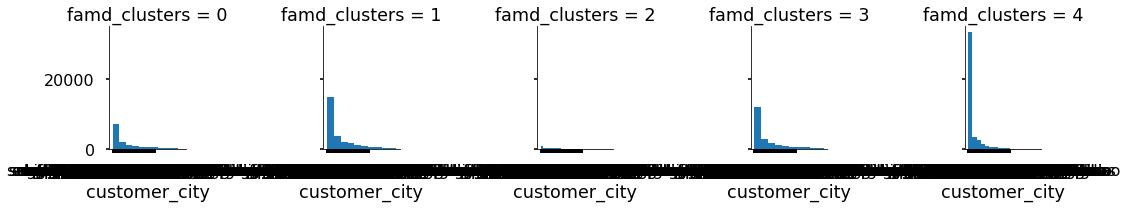

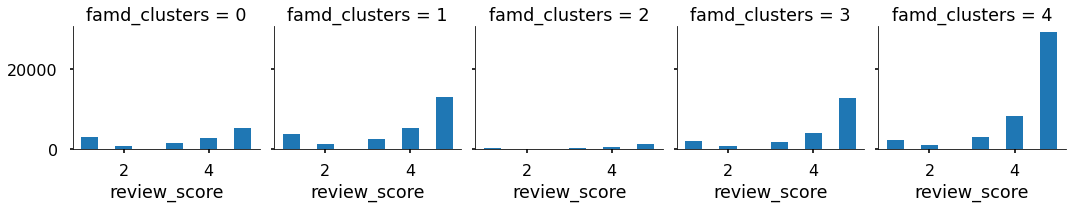

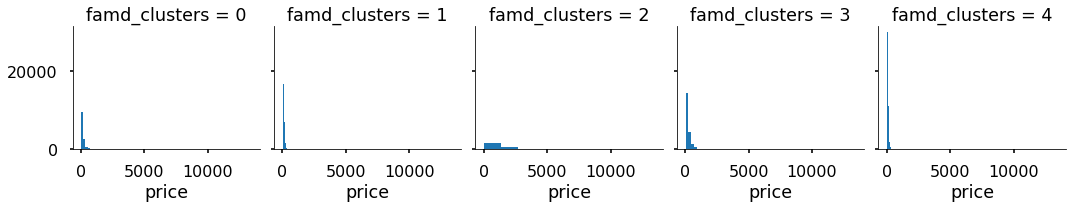

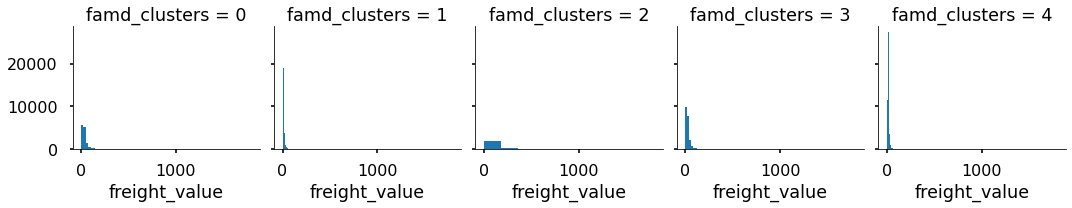

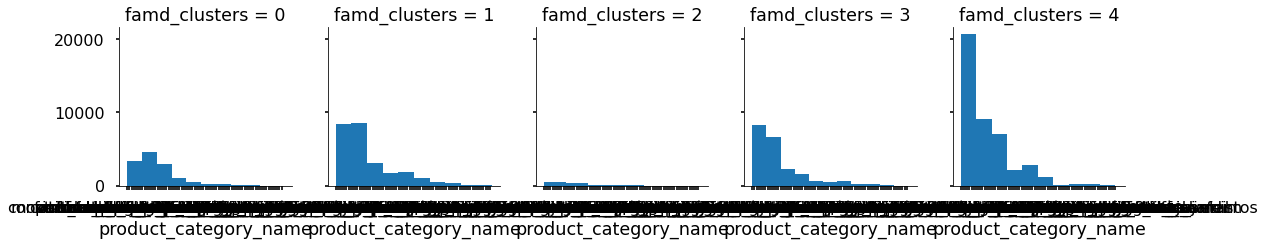

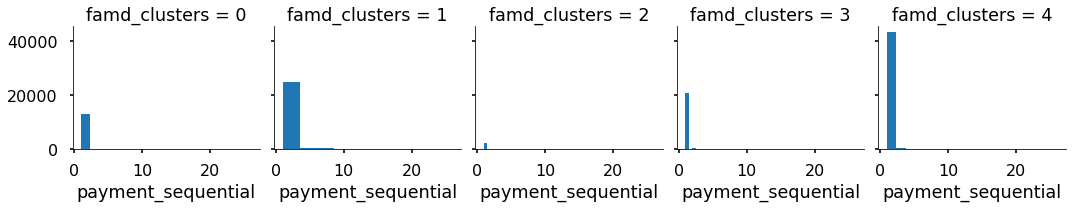

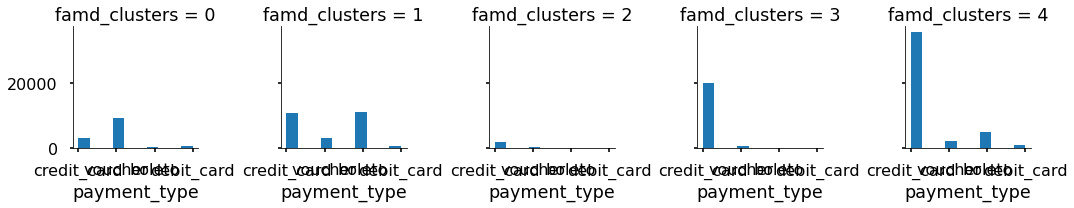

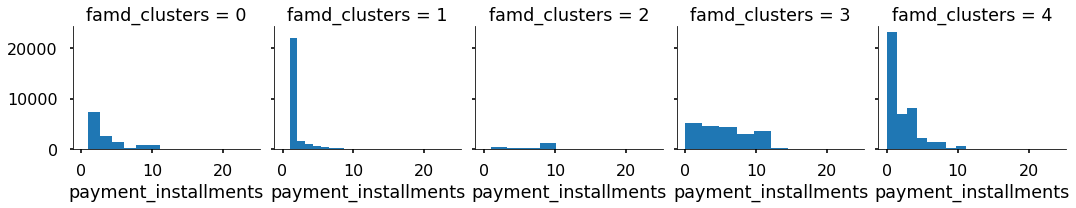

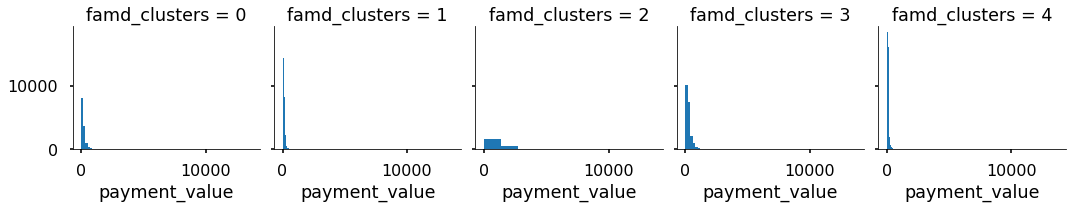

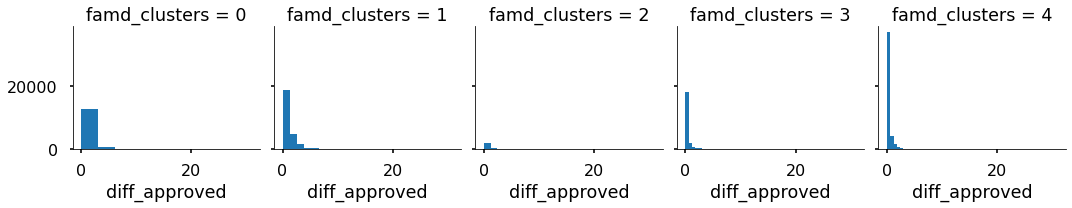

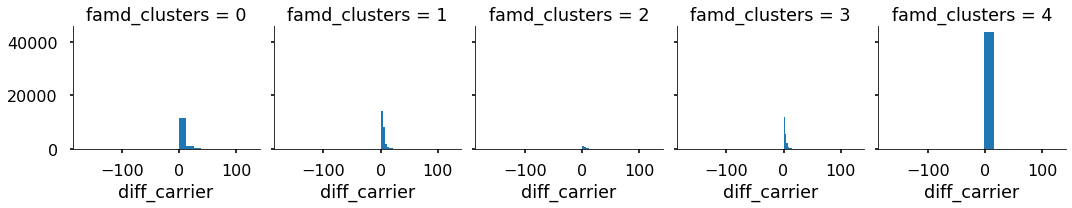

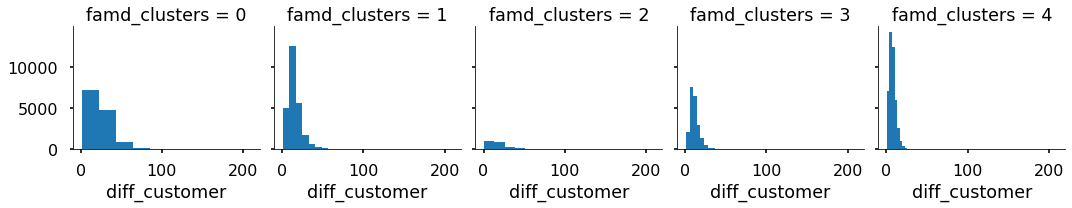

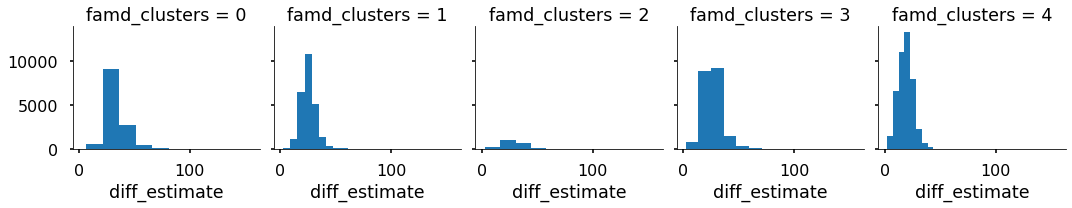

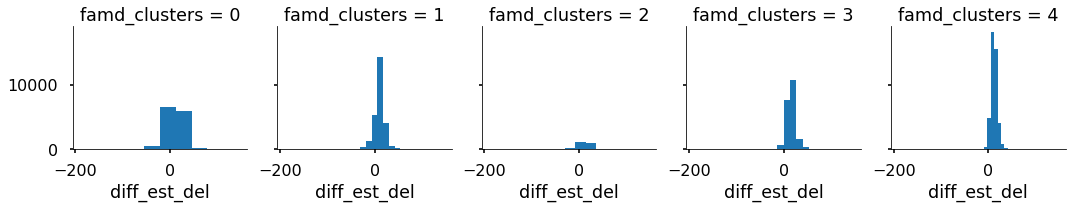

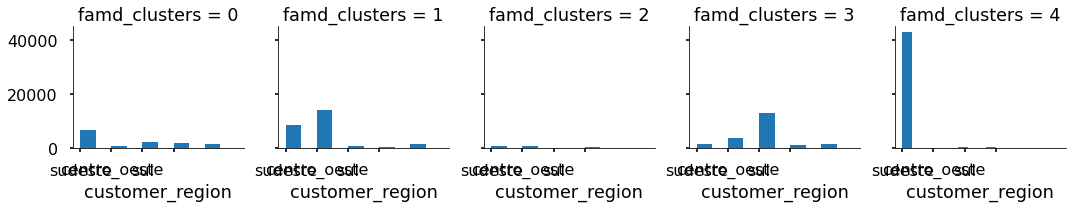

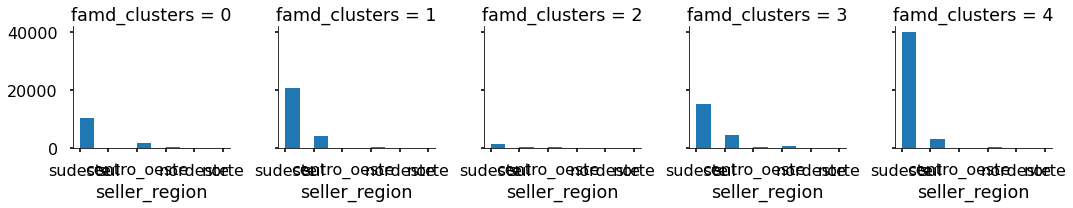

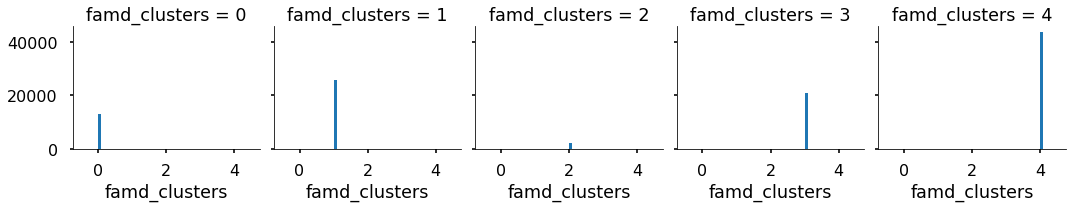

In [23]:
for c in cluster_famd_profile:
    grid = sns.FacetGrid(cluster_famd_profile, col='famd_clusters')
    grid.map(plt.hist, c)